In [1]:
%matplotlib inline

# 필요한 패키지와 라이브러리를 가져옴
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
import openpyxl
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing  import LabelEncoder
from datetime import datetime



# 데이터 가져오기

In [3]:
df_active = pd.read_excel("./data/1_Active_MS_Business_Info.xlsx", sheet_name = 0)
df_active_record = pd.read_excel("./data/1_Active_MS_Business_Info.xlsx", sheet_name = 2)
df_inactive = pd.read_excel("./data/2_Inactive_MS_Business_Info.xlsx", sheet_name = 0)
df_inactive_record = pd.read_excel("./data/2_Inactive_MS_Business_Info.xlsx", sheet_name = 1)

In [4]:
# 기업명 컬럼명 변경
df_active = df_active.rename(columns={'CMP_NM1':'CMP_NM'})

# 데이터 전처리

In [40]:
#사용할 컬럼들
select_columns = ['BIZ_NO','CMP_NM', 'CEO_NM', 'BZ_TYP',  'HDOF_BR_GB', 'FR_IVST_CORP_YN', 'VENT_YN', 'LIST_CD', 'MDSCO_PRTC_YN', 'ESTB_DATE', 'ESTB_GB', 'EMP_CNT']


In [41]:
df_active_select = df_active.loc[:, select_columns]
df_inactive_select = df_inactive.loc[:, select_columns]

In [42]:
# 업력 구간화 함수

def estb_date_calc(series):

    # 결과 값을 담을 리스트 year_category 초기화
    year_category = []

    # for 반복문을 통해 판다스 시리즈 내의 각 날짜를 순회
    for date in series:

        # 날짜의 0번째 인덱스부터 3번째 인덱스까지 슬라이싱하여 정수형(Integer)으로 변환 후 변수 year에 할당
        year = int(date[0 : 4])

        # 각 설립연도의 조건에 따라 범주화
        if year < 1970: year_category.append("1970년 이전")
        elif year < 1980: year_category.append("1970년대")
        elif year < 1990: year_category.append("1980년대")
        elif year < 2000: year_category.append("1990년대")
        elif year < 2005: year_category.append("2000년대 전기")
        elif year < 2010: year_category.append("2000년대 후기")
        elif year < 2015: year_category.append("2010년대 전기")
        elif year < 2020: year_category.append("2010년대 후기")
        elif year < 2025: year_category.append("2020년대 전기")
        else: year_category.append("해당 없음")

    # 결과 값 반환
    return year_category


# 직원수 구간화
def get_category(EMP_CNT):
    EMP_CAT = ''
    if EMP_CNT == 0 and -1: EMP_CAT = 'NaN&zero'
    elif EMP_CNT <= 10: EMP_CAT = '1~10'
    elif EMP_CNT <= 50: EMP_CAT = '10~50'
    elif EMP_CNT <= 300: EMP_CAT = '50~300'
    elif EMP_CNT > 300: EMP_CAT = '300~'
    return EMP_CAT


In [43]:
# 인코딩은 머신러닝 돌리기 전에 해주기
def encoding(df):

    #레이블 인코딩
    label_encode_features = ['BZ_TYP', 'FR_IVST_CORP_YN' , 'VENT_YN', 'MDSCO_PRTC_YN', ]

    for feature in label_encode_features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
        

    # 업력 라벨링
    estb_mapping = {"1970년 이전":0, "1970년대":1, "1980년대":2, "1990년대":3, "2000년대 전기":4, "2000년대 후기":5, "2010년대 전기":6, "2010년대 후기":7, "2020년대 전기":8, "해당 없음":9 }
    df['ESTB_DATE_CAT'] = df['ESTB_DATE_CAT'].map(estb_mapping)

    # 직원수 라벨링
    emp_mapping = {'NaN&zero':0, '1~10':1, '10~50':2, '50~300':3, '300~':4}
    df['EMP_CAT'] = df['EMP_CAT'].map(emp_mapping)

    return df

In [44]:
# 데이터 전처리 함수

def feature_engineering(df):

    # 대표자명
    df['CEO_NM'] = df['CEO_NM'].str.replace("외\s*[0-9]+명", "")


    #'LIST_CD' 상장여부로 0, 1
    df.LIST_CD.fillna(0, inplace=True)
    df['LIST_CD'].loc[df['LIST_CD']!=0]=1

    
    # 'ESTB_DATE' 설립날짜 -> 업력 구간화
    df.ESTB_DATE.fillna(99999999, inplace=True)
    # 열의 값을 str으로 변경
    df["ESTB_DATE"] = df["ESTB_DATE"].astype(str)
    # estb_date_calc() 함수를 실행한 결과를 "ESTB_DATE_CAT" 열을 새로 만들어 기존 데이터프레임에 추가
    df["ESTB_DATE_CAT"] = estb_date_calc(df["ESTB_DATE"])
    
    # 필요없는 컬럼 drop
    df = df.drop('ESTB_DATE', axis=1)
     
    # 'EMP_CNT' 직원수 구간화
    df.EMP_CNT.fillna(-1, inplace=True)
    df['EMP_CAT']=df['EMP_CNT'].apply(lambda x : get_category(x))


    return df
    

In [45]:
#이상치 처리 - 직원수가 16310명인 회사 BIZ_NO 6038138153 광평건설 직원수 22로 바꾸기(출처:bizno)
df_inactive_select['EMP_CNT'].iloc[204]=22

# feature engineering 함수 적용
df_active_select = feature_engineering(df_active_select)
df_inactive_select = feature_engineering(df_inactive_select)

C:\Users\bin\AppData\Local\Temp\ipykernel_26900\745779311.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inactive_select['EMP_CNT'].iloc[204]=22
C:\Users\bin\AppData\Local\Temp\ipykernel_26900\933713803.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['CEO_NM'] = df['CEO_NM'].str.replace("외\s*[0-9]+명", "")
C:\Users\bin\AppData\Local\Temp\ipykernel_26900\933713803.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LIST_CD'].loc[df['LIST_CD']!=0]=1
C:\Users\bin\AppData\Local\Temp\ipykernel_26900\933713803.py:6: FutureWarning: The default value of regex

In [46]:
# 직원수 컬럼 drop
df_inactive_select = df_inactive_select.drop('EMP_CNT', axis=1)
df_active_select = df_active_select.drop('EMP_CNT', axis=1)

In [47]:
df_active_select.loc[df_active_select['CEO_NM'].isnull()]

,BIZ_NO,CMP_NM,CEO_NM,BZ_TYP,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,LIST_CD,MDSCO_PRTC_YN,ESTB_GB,ESTB_DATE_CAT,EMP_CAT
28969,1678100791,오송2단지1상가개발,NaN,M,1,N,N,0,N,1,2010년대 후기,1~10


In [48]:
df_inactive_select.loc[df_inactive_select['CEO_NM'].isnull()]

,BIZ_NO,CMP_NM,CEO_NM,BZ_TYP,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,LIST_CD,MDSCO_PRTC_YN,ESTB_GB,ESTB_DATE_CAT,EMP_CAT
6606,6618800502,알엠피플러스,NaN,M,1,N,N,0,N,7,해당 없음,NaN&zero


In [14]:
# CEO_NM 결측치 active 1개, inactive 1개 - 'NaN'으로 채워줌
df_active_select['CEO_NM'].fillna('NaN', inplace=True)
df_inactive_select['CEO_NM'].fillna('NaN', inplace=True)

## 휴폐업이력sheet 컬럼 추가
- 휴폐업이력 유무(close_y_n)와 휴폐업횟수(close_count) 컬럼 만들기

In [49]:

def close_record(df):

    df.STAT_OCR_DATE.fillna(99999999, inplace=True)
    
    #close_y_n : 휴폐업 유무 컬럼
    df['close_y_n']=1

    #BIZ_NO로 set인덱스
    df=df.set_index('BIZ_NO')

    #휴폐업 조건으로 필터링한 새로운 컬럼 - 휴폐업이력 있는 기업만 들어있는 df 만들기
    close_condition = (df.CLSBZ_GB==1) | (df.CLSBZ_GB==2) | (df.CLSBZ_GB==3)
    condition_df_record = df[close_condition]

    #휴폐업 횟수 구하기
    condition_df_record = condition_df_record.groupby('BIZ_NO').sum()

    # 휴폐업 횟수 컬럼 추가
    df['close_count'] = condition_df_record['close_y_n']

    #index reset
    df = df.reset_index()

    #중복인덱스 삭제하기 - 열지정하여 중복제거
    df= df.drop_duplicates(['BIZ_NO']).reset_index(drop=True)

    return df

In [50]:
df_active_record = close_record(df_active_record)
df_inactive_record = close_record(df_inactive_record)
df_active_record.close_count.fillna(0, inplace=True)

### DF Join
- BIZ_NO 기준으로
- df_active_select + df_active_record
- df_rest_select + df_rest_record

In [51]:
#액티브 교집합(inner join) (362개)
df_active_innerjoin = pd.merge(df_active_select, df_active_record, left_on='BIZ_NO',right_on='BIZ_NO', how='inner')
df_active_innerjoin = df_active_innerjoin[['BIZ_NO', 'close_y_n', 'close_count']]

#휴폐업 기업개요와 휴폐업이력의 교집합(6693)
df_inactive_innerjoin = pd.merge(df_inactive_select, df_inactive_record,left_on='BIZ_NO',right_on='BIZ_NO', how='inner')
df_inactive_innerjoin = df_inactive_innerjoin[['BIZ_NO', 'close_y_n', 'close_count']]

#휴폐업 기업개요(6739=유니크), 휴폐업이력(6840)(유니크6746)

In [52]:
# 본 데이터프레임에 교집합innerjoin 데이터프레임 결합

df_active_join = pd.merge(df_active_select, df_active_innerjoin ,left_on='BIZ_NO',right_on='BIZ_NO', how='outer')
df_inactive_join = pd.merge(df_inactive_select, df_inactive_innerjoin ,left_on='BIZ_NO',right_on='BIZ_NO', how='outer')

In [53]:
# 널값 채우기
df_active_join = df_active_join.fillna(0)

# type 변환
df_active_join[['close_y_n', 'close_count']] = df_active_join[['close_y_n', 'close_count']].astype('int')

In [54]:
df_active_join

,BIZ_NO,CMP_NM,CEO_NM,BZ_TYP,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,LIST_CD,MDSCO_PRTC_YN,ESTB_GB,ESTB_DATE_CAT,EMP_CAT,close_y_n,close_count
0,1138111739,한일가스산업,홍순철,M,1,N,N,0,N,1,1970년 이전,10~50,0,0
1,2078132193,엠피아이,이스테판상수,M,1,N,N,0,N,1,1990년대,10~50,0,0
2,1318167565,도영운수,김명화,M,1,N,N,0,N,1,2000년대 전기,50~300,0,0
3,5048128251,중원산업,김명구,M,1,N,N,0,N,1,1990년대,50~300,0,0
4,1098164260,카타나골프,김홍득,M,1,N,N,0,N,1,2000년대 전기,1~10,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28977,8048101453,제이앤인베스트먼트,정경태,M,1,N,N,0,N,1,2010년대 후기,NaN&zero,0,0
28978,8028701430,디앤엠개발,송성현,M,1,N,N,0,N,1,2020년대 전기,1~10,0,0
28979,4268501421,마스비 건축연구소,김태남,M,2,N,N,0,N,1,1990년대,50~300,0,0
28980,6518502462,건설레미콘의정부공장,이미성,M,2,N,N,0,N,1,2020년대 전기,10~50,0,0


In [55]:
df_inactive_join

,BIZ_NO,CMP_NM,CEO_NM,BZ_TYP,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,LIST_CD,MDSCO_PRTC_YN,ESTB_GB,ESTB_DATE_CAT,EMP_CAT,close_y_n,close_count
0,1268145633,용진테크,안상동,M,1,N,N,0,N,1,2000년대 전기,10~50,1,1
1,1388101749,신구건설,소재필,M,1,N,N,0,N,1,1980년대,10~50,1,1
2,1068179240,석정미디어,이상호,M,1,N,N,0,N,1,1990년대,1~10,1,1
3,2248114507,새한실업,김정남,M,1,N,N,0,N,1,1990년대,1~10,1,1
4,1168132785,석영엔터프라이즈,박성진,M,1,N,N,0,N,1,1990년대,10~50,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6734,4808501629,게방식당팩토리,방건혁,M,2,N,N,0,N,1,2010년대 후기,1~10,1,1
6735,8018501578,우진푸드중부지점,신남정,M,2,N,N,0,N,1,2020년대 전기,10~50,1,1
6736,4118523419,윤월드푸드코리아다크써클브로스,윤인수,M,2,N,N,0,N,1,2010년대 후기,NaN&zero,1,1
6737,1738102533,기린테크,임계현,M,1,N,N,0,N,1,2020년대 전기,1~10,1,1


# 외부데이터


### 1) NICE
- (기업주소, 산업등급)
- nice 홈페이지 사업자번호 조회

In [56]:
df_nice_active = pd.read_excel("./외부data/act_company_information.xls", sheet_name = 0)
df_nice_inactive = pd.read_excel("./외부data/rest_company_information.xls", sheet_name = 0)

In [57]:
# 주소 비어있는 행 하나 (BIZ_NO : 5108119835)
df_nice_active[df_nice_active['address'].isnull()]

,BIZ_NO,grade,2021,2020,2019,address
13696,5108119835,5,"1,216,307","964,976","1,017,349",NaN


In [58]:
df_nice_active.address.fillna('NaN', inplace=True)

#### 전처리
- 1. 기업입지 도심vs부도심 -> 라벨링
- 2. grade는 그냥 사용
- 3. (매출의 증감폭)

In [59]:
city_df = pd.read_excel("./외부data/용도지역(시군구)-비도시지역_2021.xlsx", sheet_name = 0, index_col=[0,1,2])

c:\Users\bin\anaconda3\envs\numble\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [60]:
city_df.reset_index(drop=False, inplace=True)
city_df = pd.DataFrame(city_df.iloc[4:, :3])
city_df.columns=['시', '군,구', '2021']
city_df.drop(city_df.loc[city_df['군,구']=='소계'].index, inplace=True)
city_df['city'] = 0
city_df = city_df.reset_index()
city_df.drop('index', inplace=True, axis=1)

city_condition = city_df['2021']==0
city_df['city'].loc[city_condition]=1

C:\Users\bin\AppData\Local\Temp\ipykernel_26900\3754510174.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_df['city'].loc[city_condition]=1


In [61]:
# 도심(city) 컬럼 추가

df_nice_active['city'] = 0
df_nice_inactive['city'] = 0

city_index = city_df.loc[city_df['city']==1].index
city_list = city_df['군,구'][city_index].to_list()

#도시인 군,구들만 리스트 만들어서 그 안에 있으면 값 1주기
for df in [df_nice_active, df_nice_inactive] :
    for city in city_list:
        city_condition = df['address'].str.contains(city)
        df['city'].loc[city_condition]=1

C:\Users\bin\AppData\Local\Temp\ipykernel_26900\2511129021.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['city'].loc[city_condition]=1


In [62]:
# 필요한 컬럼만 선택
select_columns_ex = ['BIZ_NO', 'grade', 'city']

df_nice_active = df_nice_active[select_columns_ex]
df_nice_inactive = df_nice_inactive[select_columns_ex]

#### DF Join
- BIZ_NO 기준으로
- df_active_join + df_nice_active => active_df
- df_inactive_join + df_nice_inactive => inactive_df

In [63]:
active_df = pd.merge(df_active_join, df_nice_active, left_on='BIZ_NO', right_on='BIZ_NO', how='outer')
inactive_df = pd.merge(df_inactive_join, df_nice_inactive, left_on='BIZ_NO', right_on='BIZ_NO', how='outer')

In [64]:
active_df

,BIZ_NO,CMP_NM,CEO_NM,BZ_TYP,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,LIST_CD,MDSCO_PRTC_YN,ESTB_GB,ESTB_DATE_CAT,EMP_CAT,close_y_n,close_count,grade,city
0,1138111739,한일가스산업,홍순철,M,1,N,N,0,N,1,1970년 이전,10~50,0,0,5.0,1.0
1,2078132193,엠피아이,이스테판상수,M,1,N,N,0,N,1,1990년대,10~50,0,0,6.0,1.0
2,1318167565,도영운수,김명화,M,1,N,N,0,N,1,2000년대 전기,50~300,0,0,6.0,1.0
3,5048128251,중원산업,김명구,M,1,N,N,0,N,1,1990년대,50~300,0,0,6.0,0.0
4,1098164260,카타나골프,김홍득,M,1,N,N,0,N,1,2000년대 전기,1~10,0,0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28977,8048101453,제이앤인베스트먼트,정경태,M,1,N,N,0,N,1,2010년대 후기,NaN&zero,0,0,NaN,NaN
28978,8028701430,디앤엠개발,송성현,M,1,N,N,0,N,1,2020년대 전기,1~10,0,0,6.0,0.0
28979,4268501421,마스비 건축연구소,김태남,M,2,N,N,0,N,1,1990년대,50~300,0,0,NaN,NaN
28980,6518502462,건설레미콘의정부공장,이미성,M,2,N,N,0,N,1,2020년대 전기,10~50,0,0,NaN,NaN


In [65]:
inactive_df

,BIZ_NO,CMP_NM,CEO_NM,BZ_TYP,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,LIST_CD,MDSCO_PRTC_YN,ESTB_GB,ESTB_DATE_CAT,EMP_CAT,close_y_n,close_count,grade,city
0,1268145633,용진테크,안상동,M,1,N,N,0,N,1,2000년대 전기,10~50,1,1,NaN,NaN
1,1388101749,신구건설,소재필,M,1,N,N,0,N,1,1980년대,10~50,1,1,6.0,1.0
2,1068179240,석정미디어,이상호,M,1,N,N,0,N,1,1990년대,1~10,1,1,6.0,1.0
3,2248114507,새한실업,김정남,M,1,N,N,0,N,1,1990년대,1~10,1,1,6.0,0.0
4,1168132785,석영엔터프라이즈,박성진,M,1,N,N,0,N,1,1990년대,10~50,1,1,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6734,4808501629,게방식당팩토리,방건혁,M,2,N,N,0,N,1,2010년대 후기,1~10,1,1,NaN,NaN
6735,8018501578,우진푸드중부지점,신남정,M,2,N,N,0,N,1,2020년대 전기,10~50,1,1,NaN,NaN
6736,4118523419,윤월드푸드코리아다크써클브로스,윤인수,M,2,N,N,0,N,1,2010년대 후기,NaN&zero,1,1,NaN,NaN
6737,1738102533,기린테크,임계현,M,1,N,N,0,N,1,2020년대 전기,1~10,1,1,5.0,1.0


In [66]:
active_df['city'].value_counts()

1.0    15576
0.0    11200
Name: city, dtype: int64

In [67]:
inactive_df['city'].value_counts()

1.0    3553
0.0    2462
Name: city, dtype: int64

#### 결측치 채우기 - grade, city

In [68]:
# 필요없는 피처 drop
active_df = active_df.drop(['BIZ_NO', 'CMP_NM', 'CEO_NM'], axis=1)
inactive_df = inactive_df.drop(['BIZ_NO', 'CMP_NM', 'CEO_NM'], axis=1)

# grade - mean값으로 결측치 대체
active_df.grade.fillna(round(active_df['grade'].mean(), 2), inplace=True)
inactive_df.grade.fillna(round(inactive_df['grade'].mean(), 2), inplace=True)

# city - mean으로 결측치 대체
active_df.city.fillna(round(active_df['city'].mean(),2), inplace=True)
inactive_df.city.fillna(round(active_df['city'].mean(),2), inplace=True)

### 2) INNO_BIZ

In [519]:
inno_biz_df = pd.read_excel('./외부data/inno_biz.xlsx', header=2)
inno_biz_df = inno_biz_df.drop('번호', axis=1)

In [412]:
# '에이에스이'(innobiz) in '에이에스이 칠곡지점'(active)

In [423]:
inno_biz_df['업체명'] = inno_biz_df['업체명'].str.replace("\([^\)]+", "")
inno_biz_df['업체명'] = inno_biz_df['업체명'].str.replace("\)", "")
inno_biz_df['업체명'] = inno_biz_df['업체명'].str.replace(" *주식회사 *", "")



C:\Users\bin\AppData\Local\Temp\ipykernel_5604\3841284521.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  inno_biz_df['업체명'] = inno_biz_df['업체명'].str.replace("\([^\)]+", "")
C:\Users\bin\AppData\Local\Temp\ipykernel_5604\3841284521.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  inno_biz_df['업체명'] = inno_biz_df['업체명'].str.replace("\)", "")
C:\Users\bin\AppData\Local\Temp\ipykernel_5604\3841284521.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  inno_biz_df['업체명'] = inno_biz_df['업체명'].str.replace(" *주식회사 *", "")


In [427]:
active_df['INNO_BIZ']=0
inactive_df['INNO_BIZ']=0

In [428]:
inno_biz_df.loc[inno_biz_df['업체명'].str.contains('\(')]


,업체명,대표자,지역,평가지표,관련업종,인증만료일


In [429]:
active_df['INNO_BIZ'].value_counts()

0    28982
Name: INNO_BIZ, dtype: int64

In [430]:
inactive_df['INNO_BIZ'].value_counts()

0    6738
Name: INNO_BIZ, dtype: int64

In [431]:
inno_list = inno_biz_df['업체명'].tolist()

# 1. 기업명으로 한 번 거르기
for df in [active_df, inactive_df]:
    for inno in inno_list:
        condition = df['CMP_NM'].str.contains(inno)
        df['INNO_BIZ'].loc[condition]=1

C:\Users\bin\AppData\Local\Temp\ipykernel_5604\873086845.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INNO_BIZ'].loc[condition]=1


In [432]:
# 2. INNO_BIZ가 1인 값들만 가져와서 새로운 df만들기
active_inno_df = active_df.loc[active_df['INNO_BIZ']==1]

# 대표자명만 리스트 만들기
active_inno_list = active_inno_df['CEO_NM'].tolist()

In [433]:
# inno_biz_df 에 대표자 리스트 이름 해당값만 남겨서 다시 df만들기
new_inno_index=[]
for ac in active_inno_list:
    condition = inno_biz_df['대표자'].str.contains(ac)
    try:
        index = inno_biz_df.loc[condition].index[0]
        new_inno_index.append(index)
    except:
        pass

In [434]:
len(new_inno_index)

10397

In [435]:
# 대표자명이 동명이인이면 동명이인 수 만큼 해당 기업 정보가 중복으로 리스트에 들어감
# -> 중복제거해주기
new_inno_biz=inno_biz_df.iloc[new_inno_index,:]
new_inno_biz = new_inno_biz.drop_duplicates(['업체명']).reset_index(drop=True)

In [436]:
new_inno_biz

,업체명,대표자,지역,평가지표,관련업종,인증만료일
0,버텍스아이디,홍순철,서울 송파구,SW,정보통신,2023-11-17
1,에스더전자,김명화,서울 금천구,제조업,전기전자,2023-08-17
2,형제정공,김명구,강원 원주시,제조업,기계금속,2024-07-19
3,세풍폴리머,김종만,서울 금천구,제조업,화학,2024-12-10
4,코팅코리아,최규호,전북 김제시,제조업,기계금속,2022-10-13
...,...,...,...,...,...,...
5998,케이알씨,최영범,대구 달성군,제조업,건설,2024-10-04
5999,뉴빌리티,이상민,서울 성동구,SW,서비스,2025-06-06
6000,코리아베르톨드,이진철,경기 성남시,제조업,기계금속,2023-01-13
6001,비스텔,최운규,서울 서초구,SW,S/W,2023-12-17


In [437]:
new_inno_biz_list = new_inno_biz['대표자'].tolist()
len(new_inno_biz_list)

6003

In [438]:
active_inno_df['CMP_NM'].loc[active_inno_df['CEO_NM']=='홍순철'].tolist()

['한일가스산업', '나라삼양감속기']

In [439]:
active_inno_df['CMP_NM'].loc[active_inno_df['CEO_NM']=='김명구']

3             중원산업
14270    인천북항벌크터미널
Name: CMP_NM, dtype: object

In [440]:
test2name = new_inno_biz['업체명'].loc[new_inno_biz['대표자']=='최규호'].tolist()
test2name

['코팅코리아']

In [441]:
testlist1= ['홍순철',
 '김명화',
 '김명구',
 '김종만',
 '정득부',
 '아와츠시게키',
 '리와이킷애니타',
 '변재철',
 '최규호']
testlist2 = ['홍순철','김명화','김명구','김종만','최규호'] 

final=[]
for name in testlist1:
    if name in testlist2:
        # 대표자이름 중복 많음 - 여러개 회사 for문 돌리기
        test1name_list = active_inno_df['CMP_NM'].loc[active_inno_df['CEO_NM']==name].tolist()
        for company in test1name_list:
            test2name_list = new_inno_biz['업체명'].loc[new_inno_biz['대표자']==name].tolist()
            for company2 in test2name_list:
                if (company == company2) | (company2 in company):
                    final_company = active_inno_df['CMP_NM'].loc[active_inno_df['CEO_NM']==name].tolist()
                    final.append(final_company)

In [442]:
final

[['세풍폴리머', '가보테크', '세풍폴리머수지공장'], ['세풍폴리머', '가보테크', '세풍폴리머수지공장'], ['코팅코리아']]

In [185]:
# inno_active_list=[]
# for i in range(len(active_df)):
#     for j in range(len(inno_biz_df)):
#         if inno_biz_df['업체명'][i] in active_df['CMP_NM'][j]:
#             inno_active_list.append(inno_biz_df['업체명'][i])

In [ ]:
# inno_inactive_list=[]
# for i in range(len(inactive_df)):
#     for j in range(len(inno_biz_df)):
#         if inno_biz_df['업체명'][i] in inactive_df['CMP_NM'][j]:
#             inno_inactive_list.append(inno_biz_df['업체명'][i])

In [153]:
for df in [active_df, inactive_df]:
    for i in range(len(df)):
        # 조건 이름이 들어가 있는지 & 대표자명 포함인지.
        condition = (inno_biz_df['업체명'].str.contains(df['CMP_NM'][i])) & (inno_biz_df['대표자'].str.contains(df['CEO_NM'][i]))
        df['INNO_BIZ'].loc[condition]=1

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [146]:
for df in [active_df, inactive_df]:
    for i in range(len(inno_biz_df)):
        # 조건 이름이 들어가 있는지 & 대표자명 포함인지.
        condition = (df['CMP_NM'].str.contains(inno_biz_df['업체명'][i])) & (df['CEO_NM'].str.contains(inno_biz_df['대표자'][i]))
        df['INNO_BIZ'].loc[condition]=1

TypeError: 'in <string>' requires string as left operand, not Series

In [ ]:
# innerjoin으로 겹치는 기업 구하기
inno_active_innerjoin = pd.merge(active_df, inno_biz_df, left_on='CMP_NM', how='left')

# 데이터 시각화

'BZ_TYP',업종
'HDOF_BR_GB', 본점지점구분 1.본점 2.지점
'FR_IVST_CORP_YN', 국외투자법인여부 - N/Y
 'VENT_YN', 벤처기업여부 - N/Y 
'LIST_CD', 상장여부
LIST_DATE 상장날짜 -> 구간화
'MDSCO_PRTC_YN', 중견기업보호여부 - N/Y 
ESTB_GB	설립구분
'NATN_NM', 국가
'

 추가한 컬럼 
 ESTB_DATE 설립날짜 -> 'ESTB_DATE_CAT' 업력
 EMP_CNT 직원수 -> 'EMP_cat' 직원 수 구간화 (구간화 기준: )
 'close_y_n' 휴폐업경험 유무
 'close_count' 휴폐업 횟수
 'grade' 산업등급 (데이터출처 : nice)
 'city' 기업입지(도심,비도심) (데이터출처: nice)

In [69]:
# 액티브와 휴폐업 데이터프레임 합치기
df_join = pd.merge(active_df, inactive_df, how='outer')
df_columns = df_join.columns.tolist()
len(df_columns)

c:\Users\bin\anaconda3\envs\numble\lib\site-packages\pandas\core\reshape\merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


13

In [71]:
df_join

,BZ_TYP,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,LIST_CD,MDSCO_PRTC_YN,ESTB_GB,ESTB_DATE_CAT,EMP_CAT,close_y_n,close_count,grade,city
0,M,1,N,N,0.0,N,1,1970년 이전,10~50,0,0,5.00,1.00
1,M,1,N,N,0.0,N,1,1970년 이전,10~50,0,0,5.00,1.00
2,M,1,N,N,0.0,N,1,1970년 이전,10~50,0,0,5.00,1.00
3,M,1,N,N,0.0,N,1,1970년 이전,10~50,0,0,5.00,1.00
4,M,1,N,N,0.0,N,1,1970년 이전,10~50,0,0,5.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35714,M,1,N,N,0,N,1,2020년대 전기,NaN&zero,1,1,6.00,0.00
35715,M,1,N,N,0,N,1,2020년대 전기,50~300,1,1,6.00,0.00
35716,M,1,N,N,0,N,1,2020년대 전기,10~50,1,1,5.00,1.00
35717,M,1,N,N,0,N,1,2020년대 전기,1~10,1,1,4.00,0.00


In [302]:
df_join.corr()

,HDOF_BR_GB,ESTB_GB,close_y_n,close_count,grade,city
HDOF_BR_GB,1.000000,0.168749,0.134166,0.139489,-0.025461,0.038781
ESTB_GB,0.168749,1.000000,0.052380,0.054630,0.012493,0.008390
close_y_n,0.134166,0.052380,1.000000,0.968244,0.039279,0.010760
close_count,0.139489,0.054630,0.968244,1.000000,0.037994,0.006558
grade,-0.025461,0.012493,0.039279,0.037994,1.000000,0.032975
city,0.038781,0.008390,0.010760,0.006558,0.032975,1.000000


<AxesSubplot:>

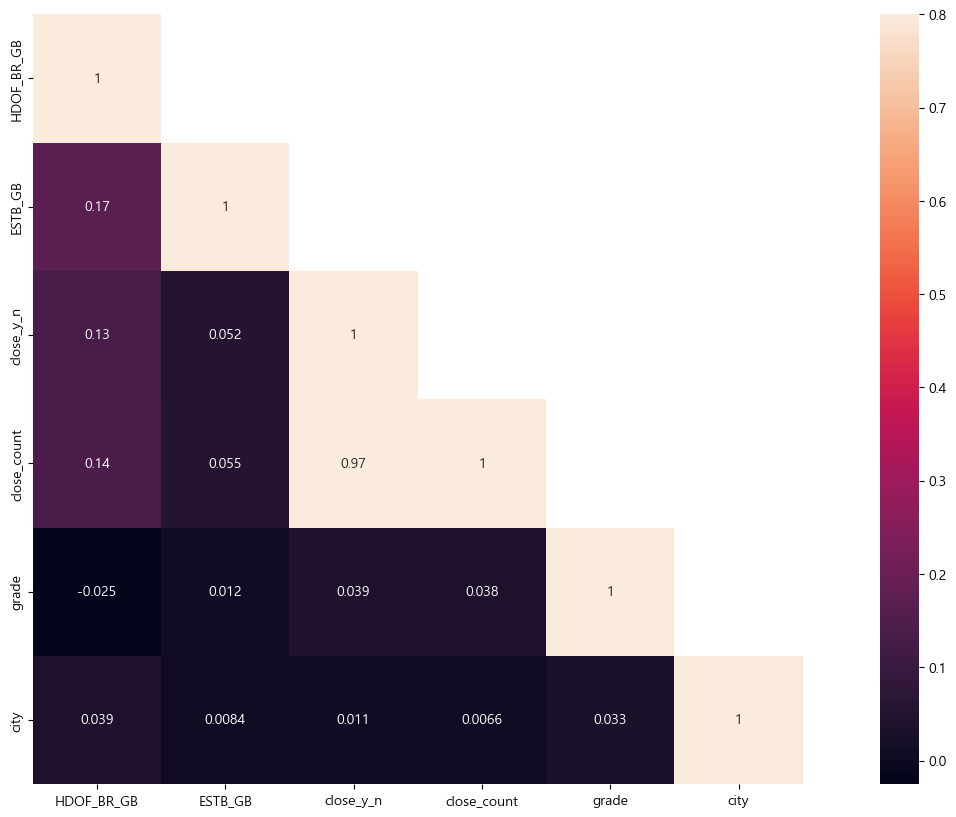

In [303]:
# 구간화나 문자들을 숫자로 인코딩하지않고 원래부터 숫자였던 것들만 상관관계 분석!
corr = df_join.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(df_join.corr(), mask=mask, vmax = .8, square=True, annot=True)

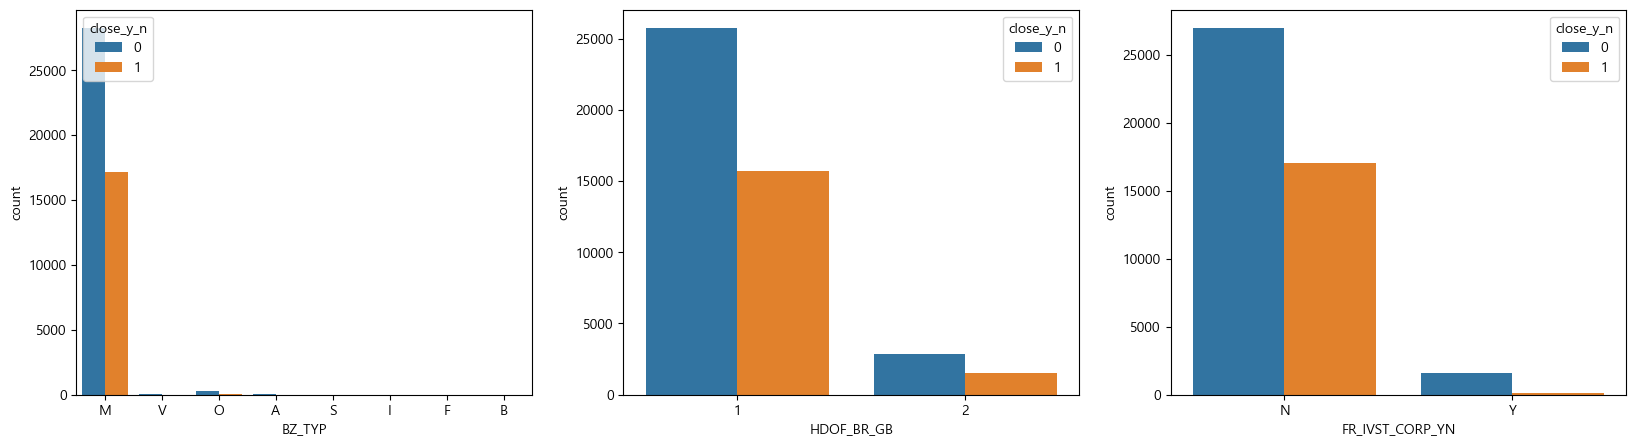

In [43]:
fig, axs = plt.subplots(figsize=(20,5), nrows=1, ncols=3)

for i, column in enumerate(['BZ_TYP','HDOF_BR_GB' ,'FR_IVST_CORP_YN']):
    sns.countplot(x=df_join[column], hue=df_join['close_y_n'], data=df_join, ax=axs[i%3])

업종 - 대부분 제조기업
본점지점구분 (1.본점 2.지점) - 대부분 본점기업
국외투자법인여부(FR_IVST_CORP_YN) - 대부분 국외투자법인 아님


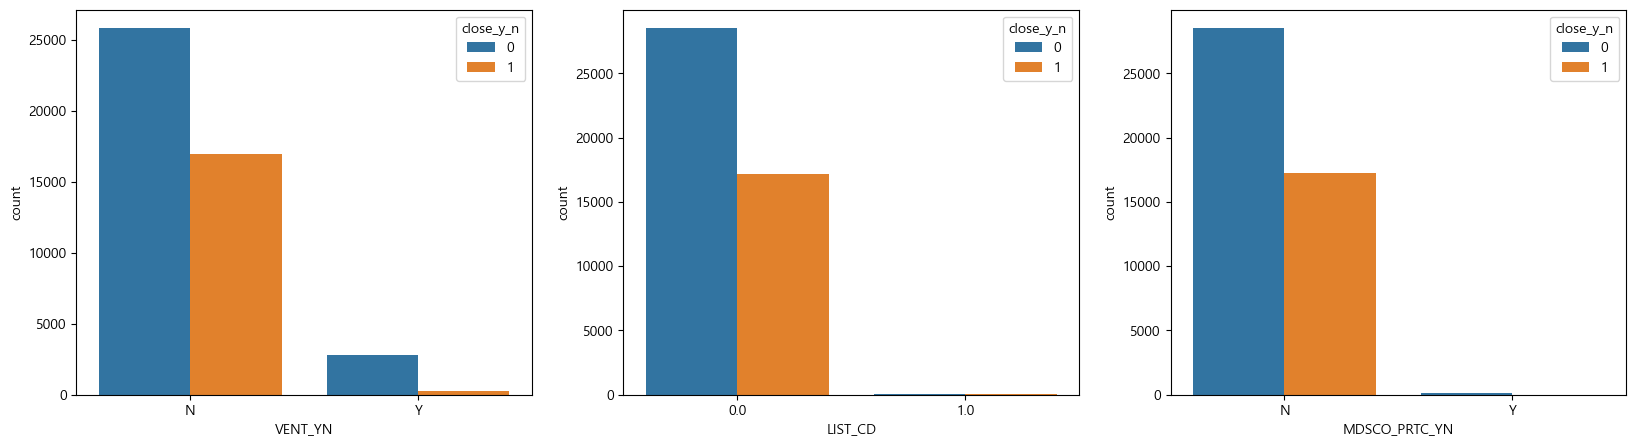

In [44]:
fig, axs = plt.subplots(figsize=(20,5), nrows=1, ncols=3)

for i, column in enumerate([ 'VENT_YN','LIST_CD', 'MDSCO_PRTC_YN']):
    sns.countplot(x=df_join[column], hue=df_join['close_y_n'], data=df_join, ax=axs[i%3])

벤처기업투자여부 - 아닌 기업이 대다수
상장여부 - 비상장기업 대다수
MDSCO_PRTC_YN - n이 99.7%

<AxesSubplot:xlabel='ESTB_DATE_CAT', ylabel='count'>

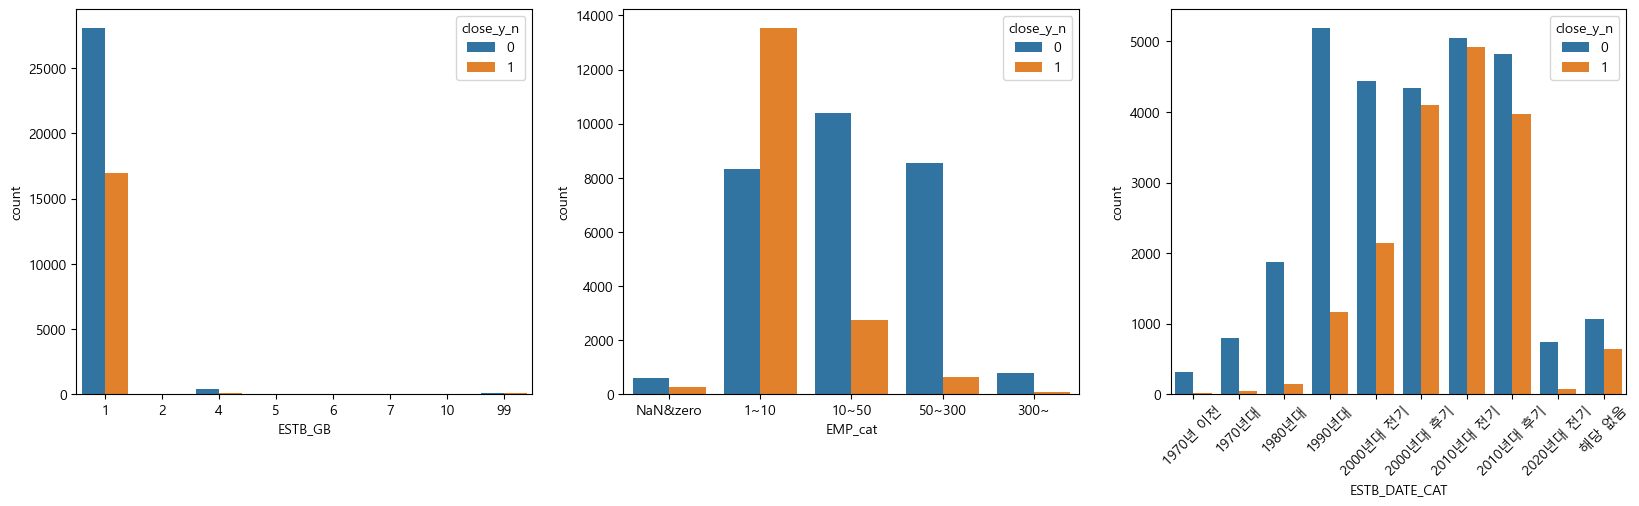

In [45]:
fig, axs = plt.subplots(figsize=(20,5), nrows=1, ncols=3)

sns.countplot(x=df_join['ESTB_GB'],hue=df_join['close_y_n'], data=df_join, ax=axs[0])
sns.countplot(x=df_join['EMP_cat'],hue=df_join['close_y_n'], data=df_join, ax=axs[1], order=['NaN&zero', '1~10', '10~50', '50~300', '300~'])
plt.xticks(rotation=45)
sns.countplot(x=df_join['ESTB_DATE_CAT'],hue=df_join['close_y_n'], data=df_join, ax=axs[2], order=['1970년 이전', '1970년대', '1980년대', '1990년대', '2000년대 전기', '2000년대 후기', '2010년대 전기', '2010년대 후기', '2020년대 전기','해당 없음'])

ESTB_GB 설립구분은 1이 99%인듯
직원수 : 1~10 이 가장 많았고 그 다음은 10~50
업력 : 1980년대부터 2010년대후기에 몰려있음. 2010년대 후기에 설립된 기업이 가장 많음

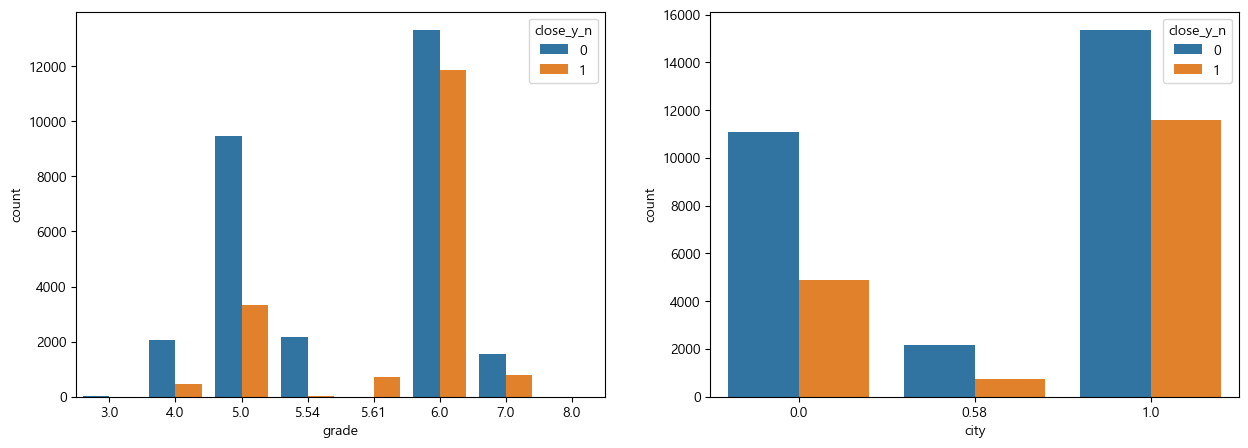

In [46]:
fig, axs = plt.subplots(figsize=(15,5), nrows=1, ncols=2)

for i, column in enumerate(['grade', 'city']):
    sns.countplot(x=df_join[column], hue=df_join['close_y_n'], data=df_join, ax=axs[i])

grade - 산업등급 5,6 기업이 많았다.
city - 도심에 위치한 기업이 많았다.

<AxesSubplot:xlabel='NATN_NM', ylabel='count'>

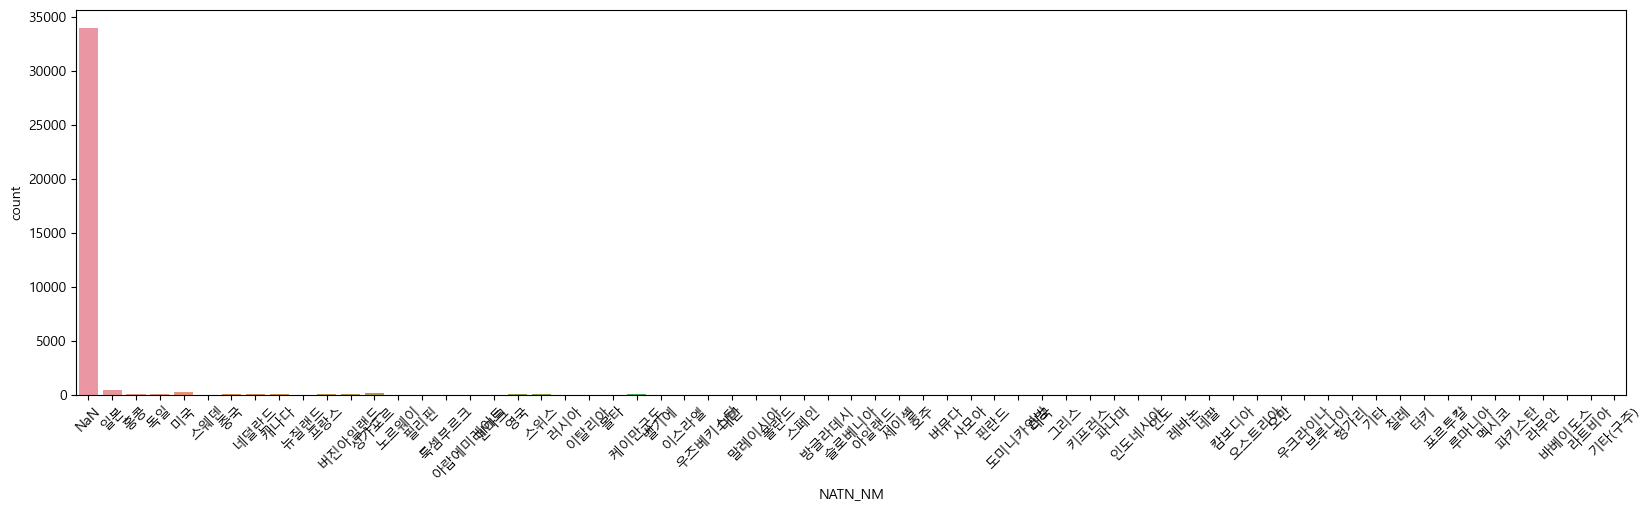

In [227]:
# 국가 NATN_NM
plt.figure(figsize=(20,5))
plt.xticks(rotation=45)
sns.countplot(x=df_join['NATN_NM'], data=df_join)

In [226]:
df_join['NATN_NM'].value_counts()

NaN       33930
일본          420
미국          291
싱가포르        161
홍콩          115
          ...  
도미니카연방        1
방글라데시         1
폴란드           1
우즈베키스탄        1
기타(구주)        1
Name: NATN_NM, Length: 65, dtype: int64

전체 데이터 35719중 널값이 33930 => 피처 삭제하는게 좋겠다

### 피처 간 관계 시각화

In [228]:
# # 나중에도 쓸 것이므로 함수로 저장 - 
# def write_text(ax, total_size):
#     for patch in ax.patches:
#         ax.text(x = patch.get_x() + patch.get_width()/2,
#                y = patch.get_height() + total_size*0.001,
#                s = f'{(patch.get_height()/total_size)*100: 1.1f}%', #소수점 1자리까지
#                ha = 'center')

BZ_TYP 업종
HDOF_BR_GB 본점지점구분 (1.본점 2.지점)
FR_IVST_CORP_YN 국외투자법인여부
VENT_YN 벤처기업여부
LIST_CD 상장여부
MDSCO_PRTC_YN 중견기업보호여부
ESTB_GB	설립구분
ESTB_DATE_CAT 업력
EMP_CAT 직원 수 구간화
close_y_n 휴폐업경험 유무
close_count 휴폐업 횟수
grade 산업등급
city 기업입지(도시,비도시)

----
산업등급, 직원수: 관계없음
업력, 직원수 , 휴=close_y_n
업력, 산업등급: 무의미
업력, 휴폐업횟수 : 최근에 설립된 기업일수록 휴페업횟수가 많다.
업력, 기업입지 : 무의미
기업입지, 산업등급 : 산업등급이 5,6,에 몰려있어서 무의미
기업입지, 휴폐업횟수 : 딱히 유의미하지않음
기업입지, VENT_YN : 딱히..
본점지점구분(HDOF_BR_GB)과 설립구분(ESTB_GB) - 이건 둘이 할 필요가 없는듯


In [72]:
# 인코딩
df_join = encoding(df_join)

In [73]:
df_join

,BZ_TYP,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,LIST_CD,MDSCO_PRTC_YN,ESTB_GB,ESTB_DATE_CAT,EMP_CAT,close_y_n,close_count,grade,city
0,4,1,0,0,0.0,0,1,0,2,0,0,5.00,1.00
1,4,1,0,0,0.0,0,1,0,2,0,0,5.00,1.00
2,4,1,0,0,0.0,0,1,0,2,0,0,5.00,1.00
3,4,1,0,0,0.0,0,1,0,2,0,0,5.00,1.00
4,4,1,0,0,0.0,0,1,0,2,0,0,5.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35714,4,1,0,0,0,0,1,8,0,1,1,6.00,0.00
35715,4,1,0,0,0,0,1,8,3,1,1,6.00,0.00
35716,4,1,0,0,0,0,1,8,2,1,1,5.00,1.00
35717,4,1,0,0,0,0,1,8,1,1,1,4.00,0.00


<AxesSubplot:xlabel='ESTB_DATE_CAT', ylabel='EMP_cat'>

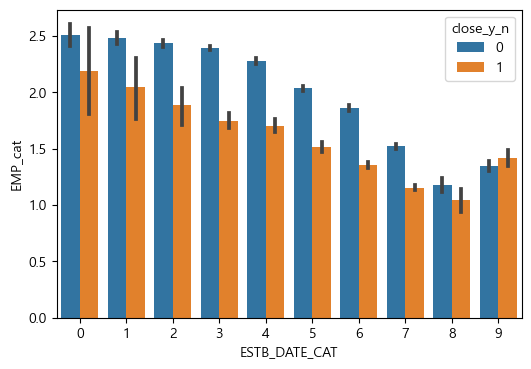

In [150]:
# 업력별 직원수 , 휴=close_y_n
plt.figure(figsize=(6,4))
sns.barplot(x=df_join['ESTB_DATE_CAT'], y = df_join['EMP_cat'], hue=df_join['close_y_n'], data=df_join)

# 오래된 기업일수록 직원수가 많다.

<AxesSubplot:xlabel='ESTB_DATE_CAT', ylabel='grade'>

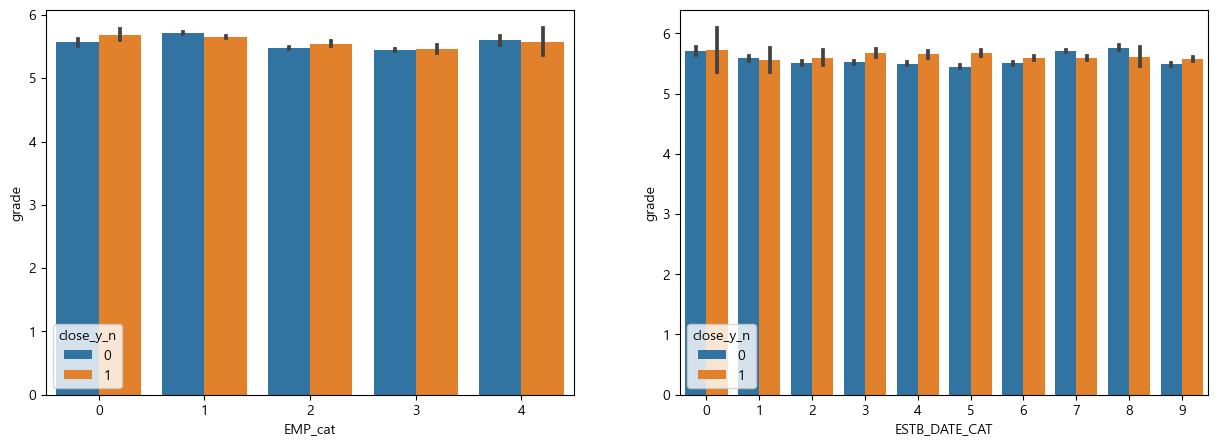

In [244]:
# 산업등급, 직원수

fig, axs = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
sns.barplot(x=df_join['EMP_cat'], y = df_join['grade'], hue=df_join['close_y_n'], data=df_join, ax=axs[0])
sns.barplot(x=df_join['ESTB_DATE_CAT'], y = df_join['grade'], hue=df_join['close_y_n'], data=df_join, ax=axs[1])

# 산업등급과 직원수는 관계가 없다.
# 업력, 산업등급도 무의미 - 산업등급이 5,6,에 몰려있어서

<AxesSubplot:xlabel='ESTB_DATE_CAT', ylabel='close_count'>

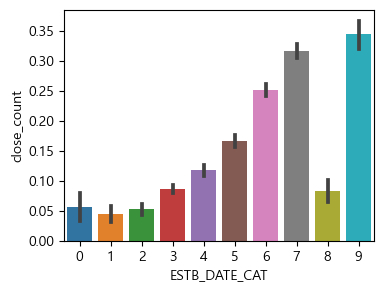

In [148]:
# 업력과 휴폐업횟수
plt.figure(figsize=(4,3))
sns.barplot(x=df_join['ESTB_DATE_CAT'], y = df_join['close_count'],data=df_join)

# 최근에 설립된 기업일수록 휴페업횟수가 많다.

<AxesSubplot:xlabel='EMP_cat', ylabel='VENT_YN'>

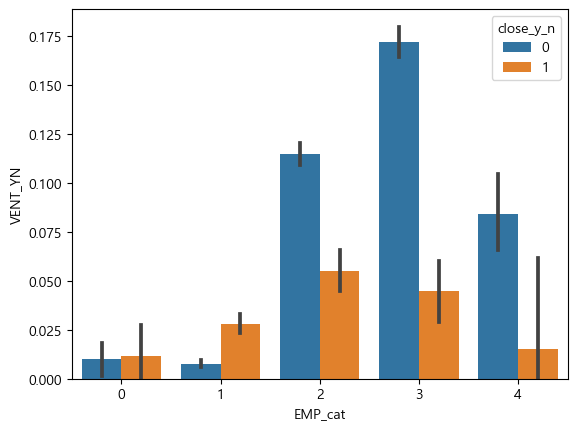

In [142]:

sns.barplot(x=df_join['EMP_cat'], y = df_join['VENT_YN'],hue=df_join['close_y_n'],  data=df_join)


NameError: name 'g' is not defined

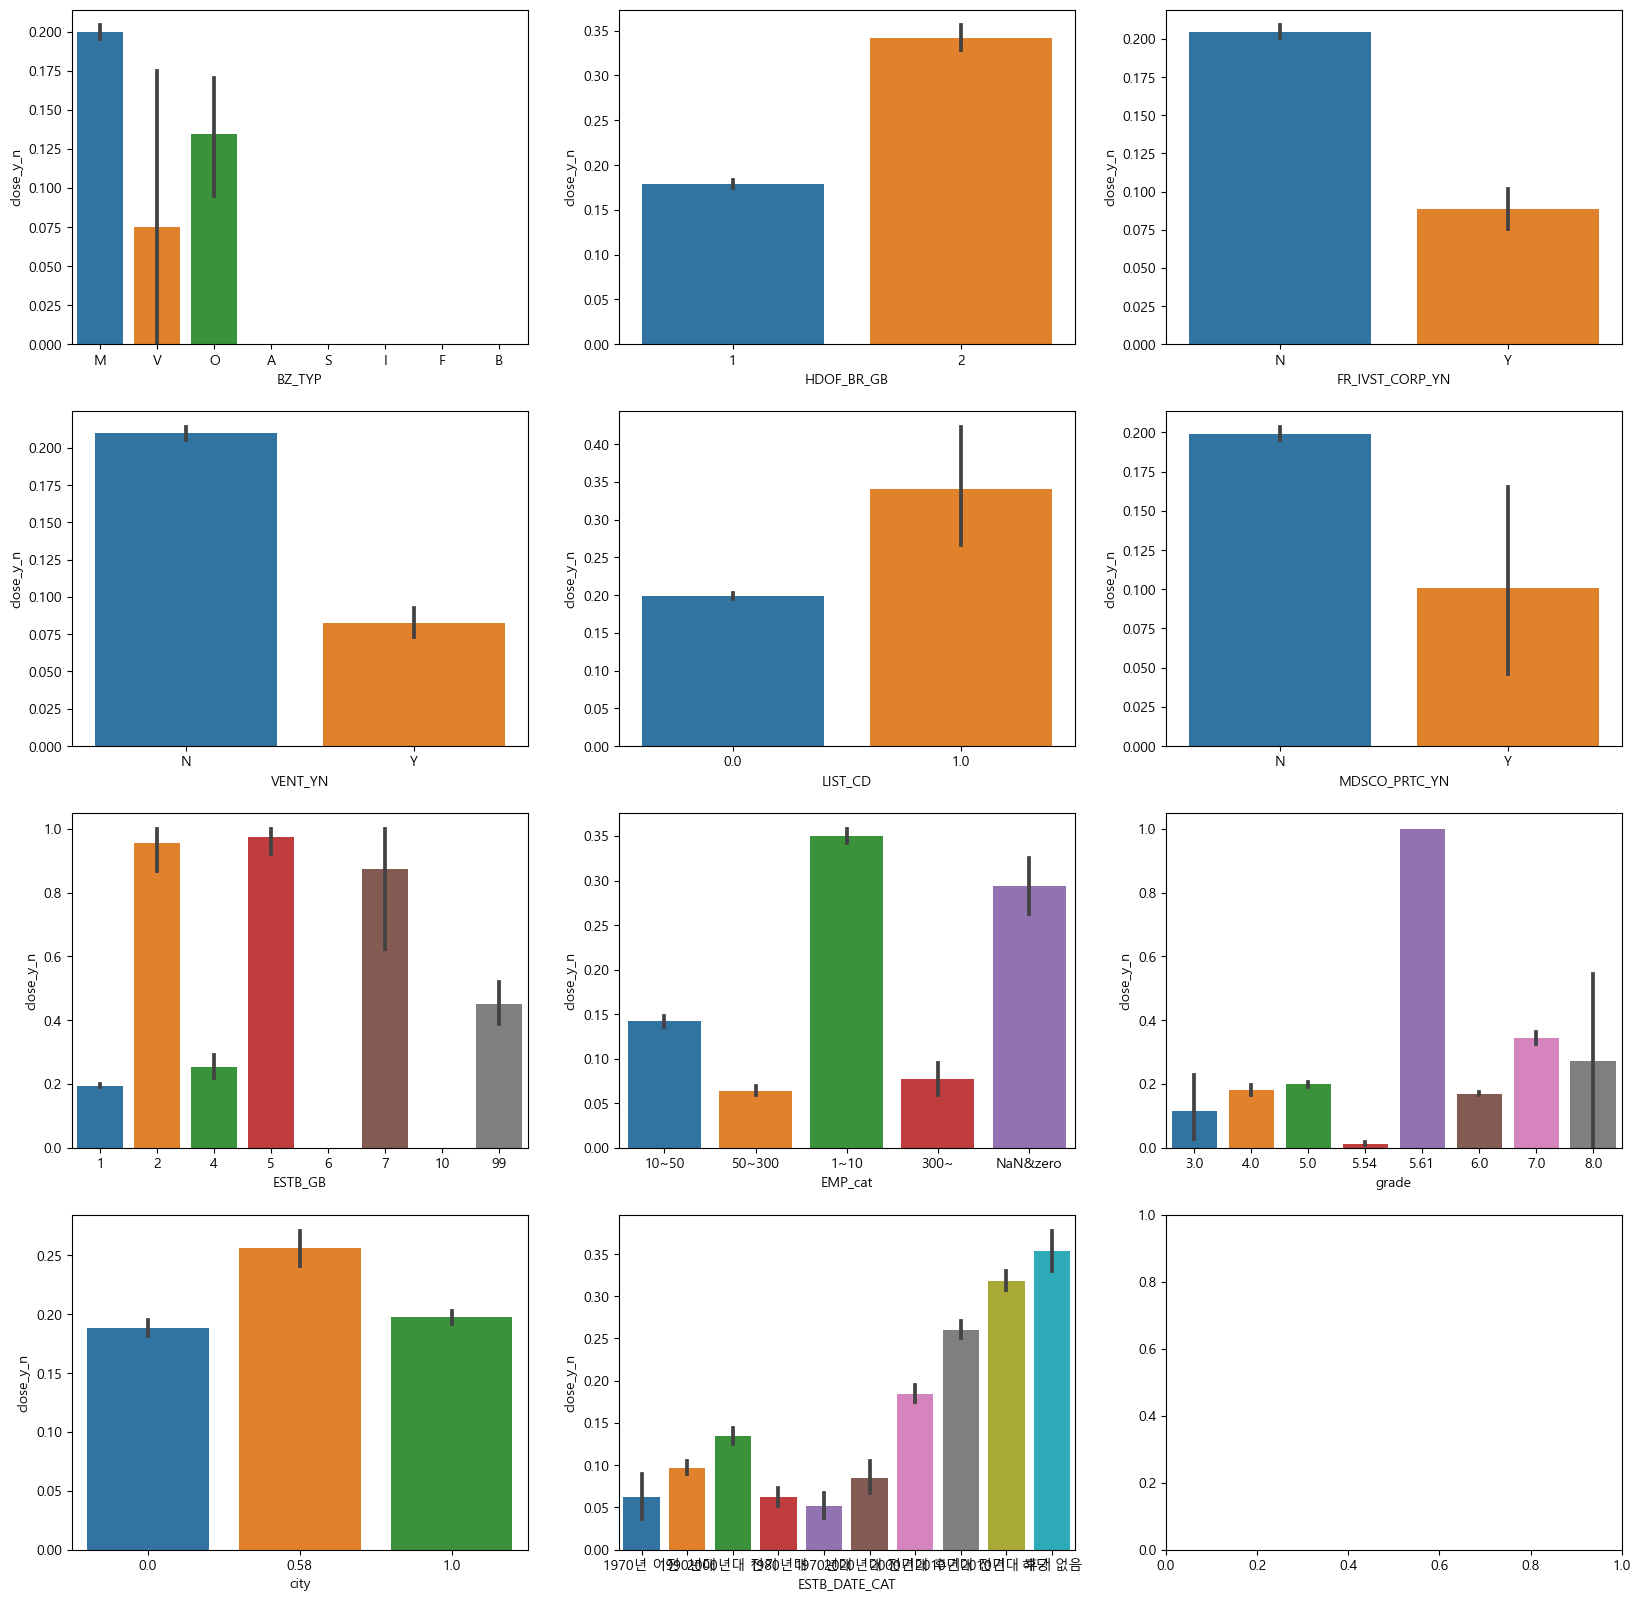

In [245]:

fig, axs = plt.subplots(figsize=(20,20), nrows=4, ncols=3)
for i, column in enumerate(df_columns):
    sns.barplot(x=df_join[column], y=df_join['close_y_n'], ax=axs[i//3][i%3])

a=sns.barplot(x=df_join['ESTB_DATE_CAT'], y=df_join['close_y_n'], ax=axs[3][1])
a.set_xticklabels(g.get_xticklabels(), rotation=45)
b=sns.barplot(x=df_join['LIST_DATE'], y=df_join['close_y_n'], ax=axs[3][2])
b.set_xticklabels(g.get_xticklabels(), rotation=45)

BZ_TYP 업종 : 0,1 많고 2도 적당히 있고 나머지는 거의 없음
EMP_cat 직원수 구간화 : 0,1 많음
LIST_DATE 상장일자 : 6,7 많음
MDSCO_PRTC_YN 중견기업보호여부 : N(0)인 경우가 많다
HDOF_BR_GB 본점지점구분 : 지점인 경우가 많다
ESTB_GB	설립구분 : 2,5,7이 다수
FR_IVST_CORP_YN 국외투자법인여부 : N(0)인 경우가 많다
VENT_YN 벤처기업여부 : N(0)인 경우가 많음
grade : 5.61 평균을 대체한 값을 제외하면 7,8,5가 다수
NATN_NM 국가 : 총 64국가
ESTB 업력 : 6,7,9 다수
LIST_CD 상장여부 : 1이 많음
city: 도심,비도심 비슷

In [ ]:
# close_count 중심으로 시각화
fig, axs = plt.subplots(figsize=(20,20), nrows=5, ncols=3)
for i, column in enumerate(df_columns):
    sns.barplot(x=df_join[column], y=df_join['close_count'], ax=axs[i%5][i%3])


ESTB_GB 값만 조금 바뀌고 거의 변화 없음

#### distplot

In [41]:
df_0 = df_join[df_join['close_y_n'] == 0]
df_1 = df_join[df_join['close_y_n'] == 1]

In [47]:
# distplot
fig, axs = plt.subplots(figsize=(20,20), nrows=5, ncols=3)
for i, column in enumerate(df_columns[:14]):
    sns.distplot(df_0[column], ax=axs[i%5][i%3])
    sns.distplot(df_1[column], ax=axs[i%5][i%3])

#### corr 상관관계, heatmap

In [235]:
df_join

,BZ_TYP,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,LIST_CD,LIST_DATE,MDSCO_PRTC_YN,ESTB_GB,NATN_NM,ESTB_DATE_CAT,EMP_cat,close_y_n,close_count,grade,city
0,M,1,N,N,0.0,해당 없음,N,1,NaN,1970년 이전,10~50,0,0,5.00,1.00
1,M,1,N,N,0.0,해당 없음,N,1,NaN,1970년 이전,10~50,0,0,5.00,1.00
2,M,1,N,N,0.0,해당 없음,N,1,NaN,1970년 이전,10~50,0,0,5.00,1.00
3,M,1,N,N,0.0,해당 없음,N,1,NaN,1970년 이전,10~50,0,0,5.00,1.00
4,M,1,N,N,0.0,해당 없음,N,1,NaN,1970년 이전,10~50,0,0,5.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35714,M,1,N,N,0,해당 없음,N,1,NaN,2020년대 전기,NaN&zero,1,1,6.00,0.00
35715,M,1,N,N,0,해당 없음,N,1,NaN,2020년대 전기,50~300,1,1,6.00,0.00
35716,M,1,N,N,0,해당 없음,N,1,NaN,2020년대 전기,10~50,1,1,5.00,1.00
35717,M,1,N,N,0,해당 없음,N,1,NaN,2020년대 전기,1~10,1,1,4.00,0.00


In [239]:
df_join.corr()

,BZ_TYP,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,LIST_DATE,MDSCO_PRTC_YN,ESTB_GB,NATN_NM,ESTB_DATE_CAT,EMP_cat,close_y_n,close_count,grade,city
BZ_TYP,1.000000,-0.017114,0.015837,-0.010870,0.008159,-0.041457,-0.007603,0.012912,0.058843,-0.044547,0.000993,0.000799,-0.001053,-0.003230
HDOF_BR_GB,-0.017114,1.000000,-0.079670,-0.112838,0.024163,0.066008,0.168749,-0.071402,0.212651,-0.098330,0.134166,0.139489,-0.025461,0.038781
FR_IVST_CORP_YN,0.015837,-0.079670,1.000000,0.010321,-0.016378,0.015332,-0.008124,0.893360,-0.057465,0.111671,-0.063070,-0.063036,-0.065878,0.040425
VENT_YN,-0.010870,-0.112838,0.010321,1.000000,-0.011899,-0.016887,-0.024280,0.012318,0.001887,0.195638,-0.088944,-0.087727,-0.112932,-0.012918
LIST_DATE,0.008159,0.024163,-0.016378,-0.011899,1.000000,-0.007268,0.002499,-0.018637,0.085711,-0.029533,0.001486,0.001760,0.010328,0.004175
MDSCO_PRTC_YN,-0.041457,0.066008,0.015332,-0.016887,-0.007268,1.000000,0.001941,0.009906,0.011182,0.005381,-0.013563,-0.012409,-0.004335,0.014185
ESTB_GB,-0.007603,0.168749,-0.008124,-0.024280,0.002499,0.001941,1.000000,-0.010524,0.052897,-0.029516,0.052380,0.054630,0.012493,0.008390
NATN_NM,0.012912,-0.071402,0.893360,0.012318,-0.018637,0.009906,-0.010524,1.000000,-0.043230,0.092123,-0.055195,-0.055429,-0.056278,0.031573
ESTB_DATE_CAT,0.058843,0.212651,-0.057465,0.001887,0.085711,0.011182,0.052897,-0.043230,1.000000,-0.414945,0.211730,0.222549,0.038044,0.000292
EMP_cat,-0.044547,-0.098330,0.111671,0.195638,-0.029533,0.005381,-0.029516,0.092123,-0.414945,1.000000,-0.278093,-0.276557,-0.122734,-0.034640


In [74]:
corr = df_join.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False

<AxesSubplot:>

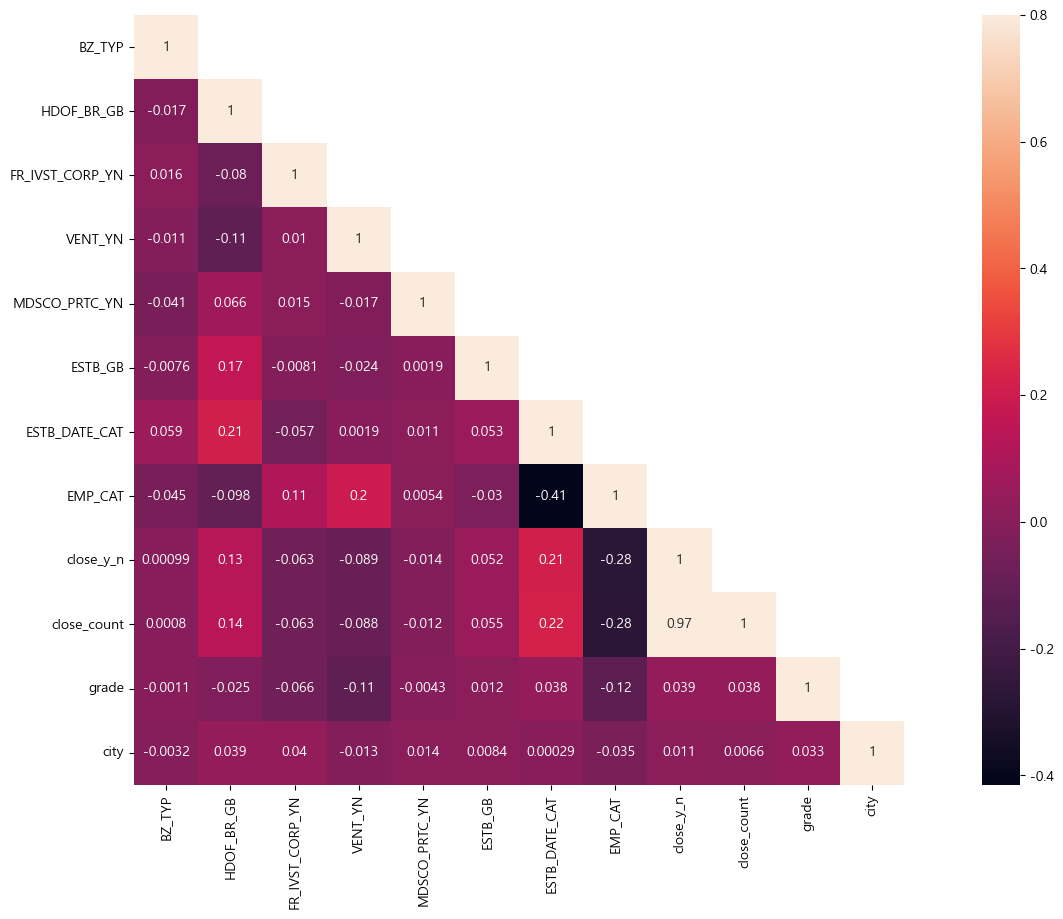

In [75]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(df_join.corr(), mask=mask, vmax = .8, square=True, annot=True)

close_y_n(타겟값) 기준으로
- BZ_TYP 업종, NATN_NM 국가는 거의 연관관계가 없다
- FR, VENT, MDSCO, EMP 도 -상관관계로 낮은 편
- 연관도가 높은 피처는 ESTB 0.21 > HDOF_BR_GB 0.13 > ESTB_GB 0.052 > grade 0.039

#### clustermap

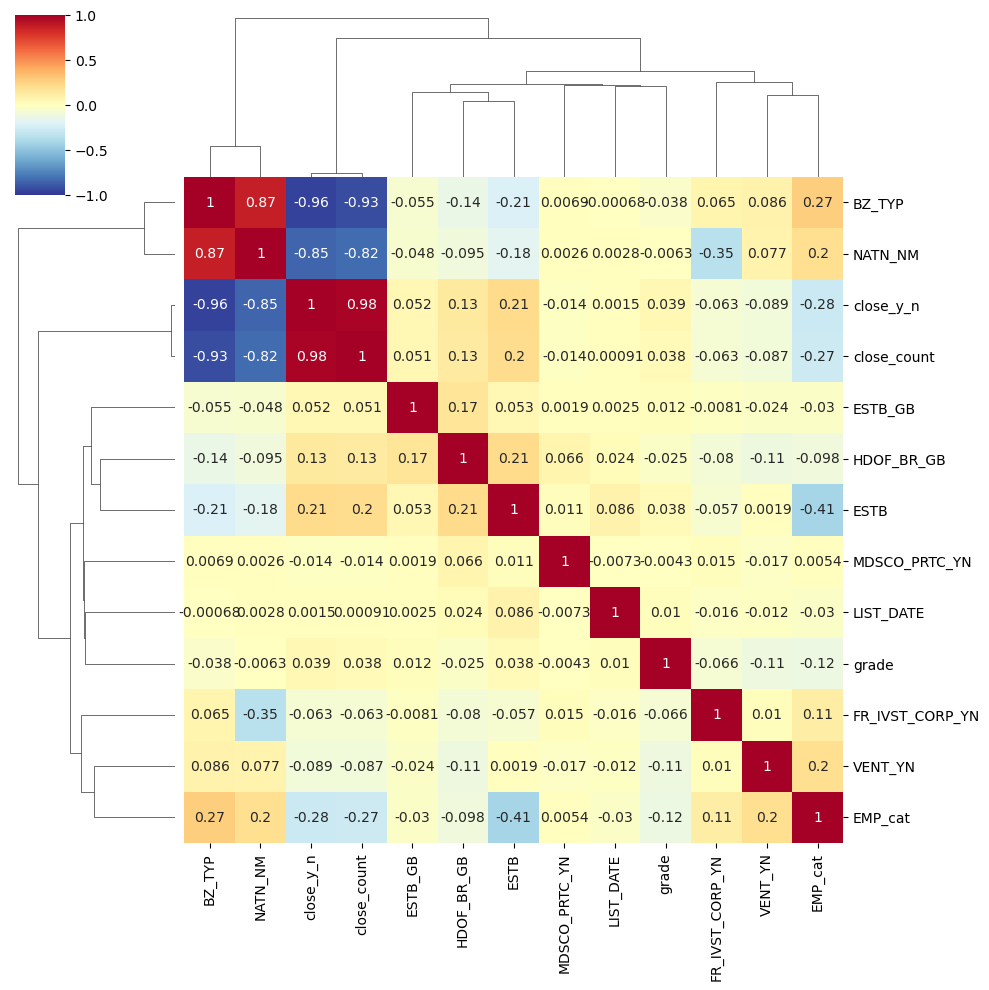

In [ ]:
sns.clustermap(corr, 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

c:\Users\bin\anaconda3\envs\numble\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\bin\anaconda3\envs\numble\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
c:\Users\bin\anaconda3\envs\numble\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\bin\anaconda3\env

<AxesSubplot:xlabel='grade', ylabel='Density'>

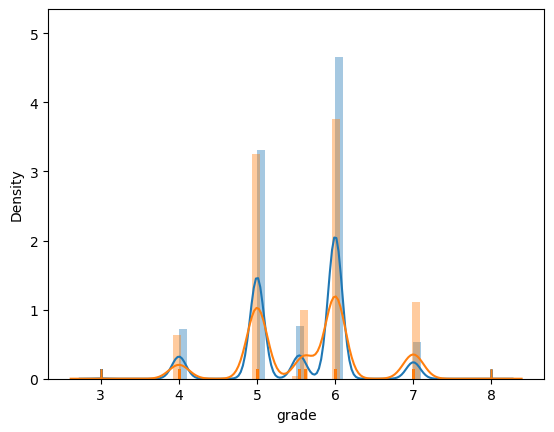

In [ ]:
# 산업 등급에 따른 휴폐업여부 시각화
sns.distplot(df_0['grade'],  rug=True, label=0)
sns.distplot(df_1['grade'],  rug=True, label=1)

<AxesSubplot:xlabel='ESTB', ylabel='ESTB_GB'>

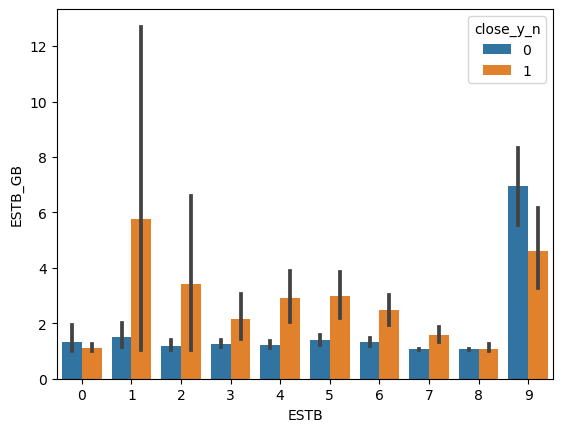

In [ ]:
sns.barplot(data=df_join, x='ESTB', y='ESTB_GB', hue='close_y_n')

# 휴폐업이력이 있는 회사는 주식회사(1)가 다수

머신러닝 돌리기 전에 라벨인코딩, 원핫인코딩 하기